In [1]:
# df_players
# name, elo, state (H/m), move time avg (not possible yet), acpl game avg
# df_games
# p1_ID, p2_ID, winner_ID, date, opening, p1_ELO, p2_ELO
# df_moves
# player_ID, game_ID, time, eval, fen/move, comment

In [2]:
import pandas as pd
import numpy as np

import chess
import chess.pgn
from stockfish import Stockfish
import os

%load_ext autoreload
%autoreload 2

In [8]:
#stockfish = Stockfish(
#    'stockfish_14_linux_x64/stockfish_14_linux_x64/stockfish_14_x64', 
#    parameters={"Threads": 2, 'Min Split Depth': 26, 'Ponder':True}
#)
#stockfish.set_elo_rating(2600)
#stockfish.set_skill_level(30)

In [7]:
%%time

players = {
    'White':[],
    'White_Elo': [],
    'Black': [],
    'Black_Elo': [],
    'WhiteIsComp':[],
}

games = {
    'Game_ID': [],
    'Date' : [],
    'White':[],  # Dummy ID
    'White_Elo': [],
    'Black': [],  # Dummy ID
    'Black_Elo': [],
    'ECO': [],
    'Result': [],
}

moves_log_dict = {
    'Game_ID': [],
    'FEN_moves': [],
    'Bitmap_moves': [],
    #'cpl': [],
    'WhiteIsComp': [],
    'turn': [],
    'Castling_right': [],
    'EP_option': [],
    'Pseudo_EP_option': [],
    'Halfmove_clock': []
    #'Result': [],
}

# Set list of Pieces
PIECES = [chess.Piece.from_symbol('P'),
         chess.Piece.from_symbol('N'),
         chess.Piece.from_symbol('B'),
         chess.Piece.from_symbol('R'),
         chess.Piece.from_symbol('Q'),
         chess.Piece.from_symbol('K'),
         chess.Piece.from_symbol('p'),
         chess.Piece.from_symbol('n'),
         chess.Piece.from_symbol('b'),
         chess.Piece.from_symbol('r'),
         chess.Piece.from_symbol('q'),
         chess.Piece.from_symbol('k')]

# read file
pgn = open("/Users/manuel/code/VPeron/cc_detector/raw_data/Fics_data_pc_data.pgn", encoding='UTF-8')  # always a Comp vs Player
game_counter = 0

while True:  # keep reading games
    try:
        game = chess.pgn.read_game(pgn)
        board = game.board()
        moves = list(game.mainline_moves())
        
        # Player
        players['White_Elo'].append(game.headers['WhiteElo'])
        players['Black_Elo'].append(game.headers['BlackElo'])
        players['White'].append(game.headers['White'])
        players['Black'].append(game.headers['Black'])
        players['WhiteIsComp'].append(game.headers.get('WhiteIsComp', 'No'))
        
        # Games
        games['Game_ID'].append(game.headers['FICSGamesDBGameNo'])
        games['White'].append(game.headers['White'])  # dummy ID
        games['Black'].append(game.headers['Black'])  # dummy ID
        games['White_Elo'].append(game.headers['WhiteElo'])
        games['Black_Elo'].append(game.headers['BlackElo'])
        games['ECO'].append(game.headers['ECO'])
        games['Result'].append(game.headers['Result'])
        games['Date'].append(game.headers['Date'])
        
        # MOVE CYCLE
        white = True
        for move in moves:
            board.push(move)
            #fen_pos.append(board.fen())
            #stockfish.set_fen_position(board.fen())  # load stockfish with current FEN for eval
            #cpl = stockfish.get_evaluation()['value']/100
            
            moves_log_dict['Game_ID'].append(game.headers['FICSGamesDBGameNo'])
            moves_log_dict['FEN_moves'].append(board.fen())
            
            #Generate bitmap representation of FENs
            bitmap_board_dict = {}
            positions = board.piece_map()

            for piece in PIECES:
                bitmap_board = {}
                for position in positions:
                    if positions[position] == piece: 
                        bitmap_board[position] = 1
                    else:
                        bitmap_board[position] = 0
                bitmap_board_dict[str(piece)] = bitmap_board            
            
            moves_log_dict['Bitmap_moves'].append(bitmap_board_dict)
            
            #moves_log_dict['cpl'].append(cpl)
            
            #Turn color and castling availablity
            moves_log_dict['WhiteIsComp'].append(game.headers.get('WhiteIsComp', 'No'))
            if white:
                moves_log_dict['turn'].append('white')
                moves_log_dict['Castling_right'].append(int(board.has_castling_rights(chess.WHITE)))
                white = False
            else:
                moves_log_dict['turn'].append('black')
                moves_log_dict['Castling_right'].append(int(board.has_castling_rights(chess.BLACK)))
                white = True
                
            #(Pseudo) en passant opportunity
            moves_log_dict['EP_option'].append(int(board.has_legal_en_passant()))
            moves_log_dict['Pseudo_EP_option'].append(int(board.has_pseudo_legal_en_passant()))
            
            #Halfmove clock
            moves_log_dict['Halfmove_clock'].append(board.halfmove_clock)
                
        game_counter += 1
        if game_counter == 50:  # number of games to read
            break
    except AttributeError:  # no further games to read
        print('No further games to load.')
        break

print(f'{game_counter} games read.')
#TODO takes ~1 sec to process 5 games, too slow.

50 games read.
CPU times: user 1.14 s, sys: 29.6 ms, total: 1.17 s
Wall time: 1.18 s


In [8]:
df_players = pd.DataFrame(players)
#TODO player ID
df_players.head()

,White,White_Elo,Black,Black_Elo,WhiteIsComp
0,forlat,1970,Geforce,2204,Yes
1,Geforce,2201,forlat,1973,No
2,forlat,1976,Geforce,2198,Yes
3,Geforce,2211,forlat,1963,No
4,forlat,1958,Geforce,2216,Yes


In [343]:
set.union(set(df_players['White']),(set(df_players['Black'])))

{'Arsyah',
 'Bjboy',
 'Geforce',
 'Genobear',
 'Ghannoum',
 'GriffySr',
 'IFDThor',
 'JMM',
 'Notarious',
 'Qiyas',
 'RamMiguel',
 'Ruvarashe',
 'chenqisheng',
 'chessloon',
 'chesspickle',
 'exeComp',
 'foggydew',
 'forlat',
 'nakshatra',
 'scalaQueen',
 'sparse',
 'sussexman'}

In [9]:
df_games = pd.DataFrame(games)
#TODO game ID
#TODO date to datetime
df_games.head()

,Game_ID,Date,White,White_Elo,Black,Black_Elo,ECO,Result
0,490373548,2021.01.31,forlat,1970,Geforce,2204,A01,0-1
1,490373541,2021.01.31,Geforce,2201,forlat,1973,B00,1-0
2,490373526,2021.01.31,forlat,1976,Geforce,2198,A20,0-1
3,490373517,2021.01.31,Geforce,2211,forlat,1963,B10,0-1
4,490373487,2021.01.31,forlat,1958,Geforce,2216,D30,1/2-1/2


In [10]:
df_moves = pd.DataFrame(moves_log_dict)
#TODO moves and cpl as features when loading to DB
#TODO game ID from df_games
df_moves.head()

,Game_ID,FEN_moves,Bitmap_moves,WhiteIsComp,turn,Castling_right,EP_option,Pseudo_EP_option,Halfmove_clock
0,490373548,rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR ...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,white,1,0,0,0
1,490373548,rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBN...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,black,1,0,0,0
2,490373548,rnbqkbnr/pppp1ppp/8/4p3/8/1PN5/P1PPPPPP/R1BQKB...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,white,1,0,0,1
3,490373548,r1bqkbnr/pppp1ppp/2n5/4p3/8/1PN5/P1PPPPPP/R1BQ...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,black,1,0,0,2
4,490373548,r1bqkbnr/pppp1ppp/2n5/4p3/8/1PN1P3/P1PP1PPP/R1...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,white,1,0,0,0


In [332]:
pgn2 = open("../raw_data/Fics_data_pc_data.pgn", encoding='UTF-8')  # always a Comp vs Player

game_string_list = []
game_counter = 0

while True: 
    
    game = chess.pgn.read_game(pgn2)
    game_string = str(game)
    game_string_list.append(game_string)
    
    game_counter += 1
    if game_counter == 50:  # number of games to read        
        break

print(game_string_list[15])

[Event "FICS rated blitz game"]
[Site "FICS freechess.org"]
[Date "2021.01.31"]
[Round "?"]
[White "Geforce"]
[Black "forlat"]
[Result "1-0"]
[BlackClock "0:03:00.000"]
[BlackElo "1986"]
[BlackIsComp "Yes"]
[BlackRD "0.0"]
[ECO "B00"]
[FICSGamesDBGameNo "490373183"]
[PlyCount "41"]
[Time "22:38:00"]
[TimeControl "180+0"]
[WhiteClock "0:03:00.000"]
[WhiteElo "2194"]
[WhiteRD "0.0"]

1. e4 { [%emt 0.0] } 1... Nc6 { [%emt 0.0] } 2. Nf3 { [%emt 0.581] } 2... e6 { [%emt 0.214] } 3. Nc3 { [%emt 0.561] } 3... Be7 { [%emt 1.164] } 4. d4 { [%emt 2.316] } 4... b6 { [%emt 1.506] } 5. Bd3 { [%emt 0.643] } 5... Nh6 { [%emt 0.951] } 6. a3 { [%emt 1.101] } 6... O-O { [%emt 0.914] } 7. h4 { [%emt 1.955] } 7... Bf6 { [%emt 1.153] } 8. e5 { [%emt 0.306] } 8... Be7 { [%emt 1.599] } 9. Bxh6 { [%emt 0.4] } 9... gxh6 { [%emt 1.764] } 10. Qd2 { [%emt 0.1] } 10... Bb7 { [%emt 1.391] } 11. Qxh6 { [%emt 0.831] } 11... f5 { [%emt 1.205] } 12. exf6 { [%emt 1.531] } 12... Rf7 { [%emt 1.797] } 13. Ng5 { [%emt 0.382

In [335]:
game.headers["Time"]

'14:24:00'

# search

In [10]:
def search_df(df, column, value):
    try:
        index = np.where(df[column] == value)
        df = df.iloc[index]
        if len(df) == 0:
            return f'No games found for {value}.'
        return df
    except KeyError as e:
        print(e, f'not found.')

In [11]:
search_df(df_moves, 'ECO', 'A01')

,Game_ID,White,Black,ECO,FEN_moves,WhiteIsComp,Result
0,490373548,forlat,Geforce,A01,[rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR...,Yes,0-1
13,490373289,forlat,Geforce,A01,[rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR...,Yes,0-1
23,490373047,forlat,Geforce,A01,[rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR...,Yes,0-1


In [74]:
move1 = chess.Move.from_uci(uci="g8f6")
move1

Move.from_uci('g8f6')

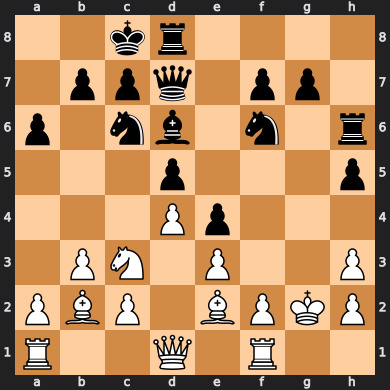

In [268]:
move = df_moves["FEN_moves"][23]
board = chess.Board(move)
board

In [79]:
board.lan(move=move1)

'Ng8-f6'

In [135]:
positions = board.piece_map()

In [137]:
PIECES = list(set((val) for val in positions.values()))
PIECES

[Piece.from_symbol('P'),
 Piece.from_symbol('N'),
 Piece.from_symbol('B'),
 Piece.from_symbol('R'),
 Piece.from_symbol('Q'),
 Piece.from_symbol('K'),
 Piece.from_symbol('p'),
 Piece.from_symbol('n'),
 Piece.from_symbol('b'),
 Piece.from_symbol('r'),
 Piece.from_symbol('q'),
 Piece.from_symbol('k')]

In [38]:
SQUARES = [i for i in range(64)]

In [42]:
for square in SQUARES:
    print(square)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [48]:
54 in positions.keys()

True

In [49]:
bitmap_board_dict = {}

for piece in PIECES:
    bitmap_board = {}
    for square in SQUARES:
        if square in positions.keys():
            if positions[square] == piece: 
                bitmap_board[square] = 1
            else:
                bitmap_board[square] = 0
        else:
            bitmap_board[square] = 0
    bitmap_board_dict[str(piece)] = bitmap_board

In [50]:
bitmap_board_dict

{'P': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 0,
  16: 0,
  17: 0,
  18: 0,
  19: 0,
  20: 0,
  21: 0,
  22: 1,
  23: 0,
  24: 0,
  25: 0,
  26: 0,
  27: 0,
  28: 0,
  29: 0,
  30: 1,
  31: 1,
  32: 0,
  33: 0,
  34: 0,
  35: 0,
  36: 0,
  37: 0,
  38: 0,
  39: 0,
  40: 0,
  41: 0,
  42: 0,
  43: 0,
  44: 0,
  45: 0,
  46: 0,
  47: 0,
  48: 0,
  49: 0,
  50: 0,
  51: 0,
  52: 0,
  53: 0,
  54: 0,
  55: 0,
  56: 0,
  57: 0,
  58: 0,
  59: 0,
  60: 0,
  61: 0,
  62: 0,
  63: 0},
 'N': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 0,
  16: 0,
  17: 0,
  18: 0,
  19: 0,
  20: 0,
  21: 0,
  22: 0,
  23: 0,
  24: 0,
  25: 0,
  26: 0,
  27: 0,
  28: 0,
  29: 0,
  30: 0,
  31: 0,
  32: 0,
  33: 0,
  34: 0,
  35: 0,
  36: 0,
  37: 0,
  38: 0,
  39: 0,
  40: 0,
  41: 0,
  42: 0,
  43: 0,
  44: 0,
  45: 0,
  46: 0,
  47: 0,
 

In [242]:
board.has_legal_en_passant()

True

In [243]:
board.has_pseudo_legal_en_passant()

True

In [269]:
board.halfmove_clock

1

# Data import with package

In [1]:
from cc_detector import data

In [3]:
player_df2, game_df2, move_df2 = data.ChessData().import_data(data_path='../raw_data/Fics_data_pc_data.pgn', 
                                                              import_lim=50)


50 games read.


In [4]:
move_df2['Move_ID'] = move_df2.apply(lambda row: f"{row.Game_ID }-{row.White}-{row.Black}", axis=1)

,Game_ID,FEN_moves,Bitmap_moves,WhiteIsComp,turn,Castling_right,EP_option,Pseudo_EP_option,Halfmove_clock
0,490373548,rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR ...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,1,0,0,0
1,490373548,rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBN...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,black,1,0,0,0
2,490373548,rnbqkbnr/pppp1ppp/8/4p3/8/1PN5/P1PPPPPP/R1BQKB...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,1,0,0,1
3,490373548,r1bqkbnr/pppp1ppp/2n5/4p3/8/1PN5/P1PPPPPP/R1BQ...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,black,1,0,0,2
4,490373548,r1bqkbnr/pppp1ppp/2n5/4p3/8/1PN1P3/P1PP1PPP/R1...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,1,0,0,0
...,...,...,...,...,...,...,...,...,...
2672,490368781,8/5pk1/4p2p/6p1/p2K2PP/3B2P1/1r6/8 b - - 1 41,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,0,0,0,1
2673,490368781,8/5pk1/4p2p/6p1/3K2PP/p2B2P1/1r6/8 w - - 0 42,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,black,0,0,0,0
2674,490368781,8/5pk1/4p2p/6p1/6PP/p1KB2P1/1r6/8 b - - 1 42,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,0,0,0,1
2675,490368781,8/5pk1/1r2p2p/6p1/6PP/p1KB2P1/8/8 w - - 2 43,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,black,0,0,0,2


## Binary vector representation for board

In [5]:
df_test = pd.DataFrame(move_df2['Bitmap_moves'][0])

In [6]:
df_test

,P,N,B,R,Q,K,p,n,b,r,q,k
0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
59,0,0,0,0,0,0,0,0,0,0,1,0
60,0,0,0,0,0,0,0,0,0,0,0,1
61,0,0,0,0,0,0,0,0,1,0,0,0
62,0,0,0,0,0,0,0,1,0,0,0,0


In [7]:
dict_wide = {}

for index1, i in enumerate(df_test.columns):
    for index2, j in enumerate(df_test.index):
        dict_wide[str(i)+str(j)] = [df_test.iloc[index2, index1]]

In [8]:
dict_wide

{'P0': [0],
 'P1': [0],
 'P2': [0],
 'P3': [0],
 'P4': [0],
 'P5': [0],
 'P6': [0],
 'P7': [0],
 'P8': [1],
 'P9': [0],
 'P10': [1],
 'P11': [1],
 'P12': [1],
 'P13': [1],
 'P14': [1],
 'P15': [1],
 'P16': [0],
 'P17': [1],
 'P18': [0],
 'P19': [0],
 'P20': [0],
 'P21': [0],
 'P22': [0],
 'P23': [0],
 'P24': [0],
 'P25': [0],
 'P26': [0],
 'P27': [0],
 'P28': [0],
 'P29': [0],
 'P30': [0],
 'P31': [0],
 'P32': [0],
 'P33': [0],
 'P34': [0],
 'P35': [0],
 'P36': [0],
 'P37': [0],
 'P38': [0],
 'P39': [0],
 'P40': [0],
 'P41': [0],
 'P42': [0],
 'P43': [0],
 'P44': [0],
 'P45': [0],
 'P46': [0],
 'P47': [0],
 'P48': [0],
 'P49': [0],
 'P50': [0],
 'P51': [0],
 'P52': [0],
 'P53': [0],
 'P54': [0],
 'P55': [0],
 'P56': [0],
 'P57': [0],
 'P58': [0],
 'P59': [0],
 'P60': [0],
 'P61': [0],
 'P62': [0],
 'P63': [0],
 'N0': [0],
 'N1': [1],
 'N2': [0],
 'N3': [0],
 'N4': [0],
 'N5': [0],
 'N6': [1],
 'N7': [0],
 'N8': [0],
 'N9': [0],
 'N10': [0],
 'N11': [0],
 'N12': [0],
 'N13': [0],
 'N14'

In [9]:
pd.DataFrame(dict_wide)

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k54,k55,k56,k57,k58,k59,k60,k61,k62,k63
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [10]:
from cc_detector.move import binary_board_df

In [18]:
df_wide = binary_board_df(move_df2)
#very inefficient so far (takes very long, probably needs to be redone differently)

In [37]:
df_wide

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k54,k55,k56,k57,k58,k59,k60,k61,k62,k63
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2673,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2674,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2675,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
